# House Prices - Predicting sales

## Alex Braithwaite

# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
style.use('seaborn-colorblind')
%matplotlib inline

RANDOM_STATE = 42

import warnings
warnings.filterwarnings('ignore')

# Loading the data

In [2]:
# Training set
train_df = pd.read_csv('train.csv')
# Test set
test_df = pd.read_csv('test.csv')

In [3]:
train_df.drop(['Id'], axis = 1, inplace = True)

## Data exploration

## Imputing missing numerical values

In [4]:
# Get numerical columns
num_cols = train_df.select_dtypes(include=[np.number])

#num_cols.isnull().sum()

In [5]:
# Check pair-wise correlations to look for variables that correlate to impute missing values
corr = train_df.corr().abs()

unstack = corr.unstack()

pairs = unstack.sort_values(ascending = False)
pairs['LotFrontage'][:4] # Top 4 correlated variables for LotFrontage

LotFrontage    1.000000
1stFlrSF       0.457181
LotArea        0.426095
GrLivArea      0.402797
dtype: float64

In [6]:
pairs['GarageYrBlt'][:4] 

GarageYrBlt     1.000000
YearBuilt       0.825667
YearRemodAdd    0.642277
GarageCars      0.588920
dtype: float64

In [7]:
pairs['MasVnrArea'][:4]

MasVnrArea     1.000000
SalePrice      0.477493
OverallQual    0.411876
GrLivArea      0.390857
dtype: float64

In [8]:
# MSSubClass is fairly correlated with LotFrontage therefore group by to get more depth in the imputation
grouped = train_df.groupby(['MSSubClass'])
train_df['LotFrontage'] = grouped['LotFrontage'].apply(lambda x: x.fillna(x.mean()))

In [9]:
# MSSubClass is fairly correlated with LotFrontage therefore group by to get more depth in the imputation
group = test_df.groupby(['MSSubClass'])
test_df['LotFrontage'] = group['LotFrontage'].apply(lambda x: x.fillna(x.mean()))

In [10]:
# Fill null values for garage year with the year the house of built since a fairly high correlation
train_df['GarageYrBlt'].fillna(train_df['YearBuilt'], inplace = True)

In [11]:
test_df['GarageYrBlt'].fillna(test_df['YearBuilt'], inplace = True)

In [12]:
# OverallQual is fairly correlated with MasVnrArea therefore group by to get more depth in the imputation
grouped = train_df.groupby(['OverallQual'])
train_df['MasVnrArea'] = grouped['MasVnrArea'].apply(lambda x: x.fillna(x.mean()))

In [13]:
group = test_df.groupby(['OverallQual'])
test_df['MasVnrArea'] = group['MasVnrArea'].apply(lambda x: x.fillna(x.mean()))

In [14]:
test_df.fillna(test_df.mean(), inplace = True)

In [15]:
# Get categorical columns
cat_cols = train_df.select_dtypes(include=['object'])

cat_cols.isnull().sum()

MSZoning            0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinType2       38
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
KitchenQual         0
Functional          0
FireplaceQu       690
GarageType         81
GarageFinish       81
GarageQual         81
GarageCond         81
PavedDrive          0
PoolQC           1453
Fence            1179
MiscFeature      1406
SaleType            0
SaleCondition       0
dtype: int64

In [16]:
# Set NaN values to NaN to signify correctly that they don't have the quality related to the variable - Assumed
for column in cat_cols.columns.values:
    if cat_cols[column].isnull().values.any():
        train_df[column] = train_df[column].fillna('NA')

In [17]:
cat_cols = test_df.select_dtypes(include=['object'])
for column in cat_cols.columns.values:
    if cat_cols[column].isnull().values.any():
        test_df[column] = test_df[column].fillna('NA')

In [18]:
# All missing values imputed
(train_df.isnull().sum() * 100 / len(train_df)).sort_values(ascending=False)

SalePrice        0.0
SaleCondition    0.0
RoofMatl         0.0
Exterior1st      0.0
Exterior2nd      0.0
MasVnrType       0.0
MasVnrArea       0.0
ExterQual        0.0
ExterCond        0.0
Foundation       0.0
BsmtQual         0.0
BsmtCond         0.0
BsmtExposure     0.0
BsmtFinType1     0.0
BsmtFinSF1       0.0
BsmtFinType2     0.0
BsmtFinSF2       0.0
BsmtUnfSF        0.0
TotalBsmtSF      0.0
RoofStyle        0.0
YearRemodAdd     0.0
YearBuilt        0.0
Utilities        0.0
MSZoning         0.0
LotFrontage      0.0
LotArea          0.0
Street           0.0
Alley            0.0
LotShape         0.0
LandContour      0.0
                ... 
PoolArea         0.0
GarageCars       0.0
PoolQC           0.0
Fence            0.0
MiscFeature      0.0
MiscVal          0.0
MoSold           0.0
YrSold           0.0
SaleType         0.0
GarageArea       0.0
GarageFinish     0.0
Electrical       0.0
HalfBath         0.0
1stFlrSF         0.0
2ndFlrSF         0.0
LowQualFinSF     0.0
GrLivArea    

## Feature Engineering

### Distributions

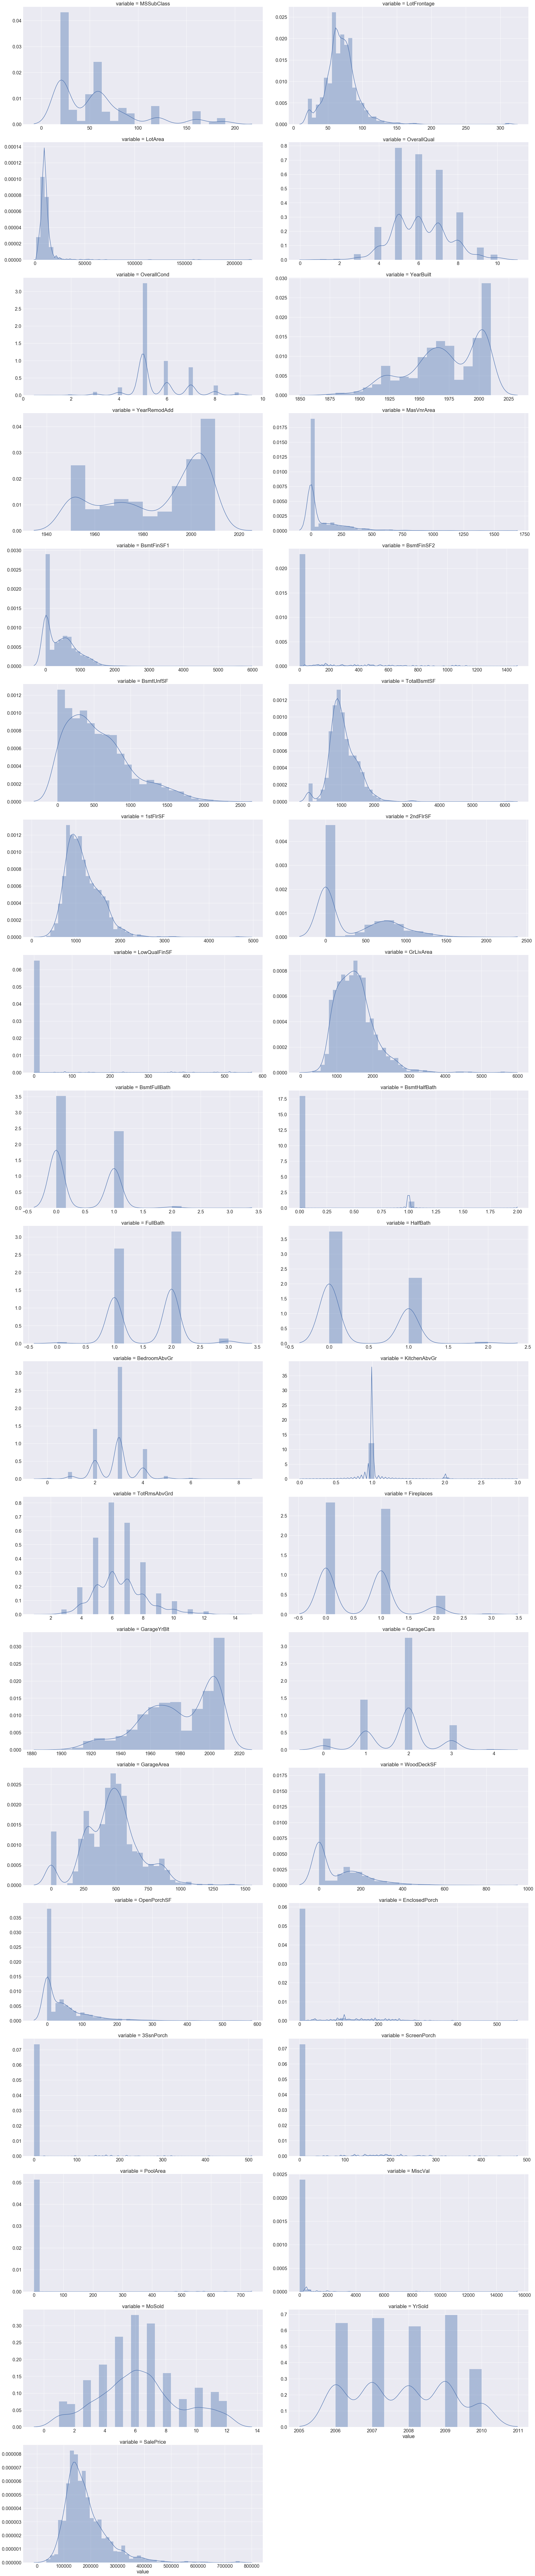

In [19]:
# Distribution of numerical variables
sns.set(font_scale=2)
f = pd.melt(num_cols, value_vars=num_cols)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=8, aspect=2)
g = g.map(sns.distplot, "value")

In [20]:
#MSSubClass redefining categories
bin_ranges = [20,40,50,75,90,180,190]
bin_names = ['1 Story','1-1/2 Story', '2 Story', 'Split', 'PUD', 'Family Conversion']

train_df['MSSubClass'] = pd.cut(np.array(train_df['MSSubClass']), bins=bin_ranges, labels=bin_names, include_lowest=True)

In [21]:
test_df['MSSubClass'] = pd.cut(np.array(test_df['MSSubClass']), bins=bin_ranges, labels=bin_names, include_lowest=True)

In [22]:
# Group OverallQual and OverallCond in to the below categories
# Ex	Excellent
# Gd	Good
# TA	Typical/Average
# Fa	Fair
# Po	Poor

# OverallQual
train_df['OverallQual'].loc[(train_df['OverallQual'] == 1) | (train_df['OverallQual'] == 2)] = 'Po'
train_df['OverallQual'].loc[(train_df['OverallQual'] == 3)] = 'Fa'
train_df['OverallQual'].loc[(train_df['OverallQual'] == 4) | (train_df['OverallQual'] == 5)] = 'TA'
train_df['OverallQual'].loc[(train_df['OverallQual'] == 6) | (train_df['OverallQual'] == 7) | (train_df['OverallQual'] == 8)] = 'Gd'
train_df['OverallQual'].loc[(train_df['OverallQual'] == 9) | (train_df['OverallQual'] == 10)] = 'Ex'

# OverallCond
train_df['OverallCond'].loc[(train_df['OverallCond'] == 2) | (train_df['OverallCond'] == 1)] = 'Po'
train_df['OverallQual'].loc[(train_df['OverallCond'] == 3)] = 'Fa'
train_df['OverallCond'].loc[(train_df['OverallCond'] == 4) | (train_df['OverallCond'] == 5)] = 'TA'
train_df['OverallCond'].loc[(train_df['OverallCond'] == 6) | (train_df['OverallCond'] == 7) | (train_df['OverallCond'] == 8)] = 'Gd'
train_df['OverallCond'].loc[(train_df['OverallCond'] == 9) | (train_df['OverallCond'] == 10)] = 'Ex'

In [23]:
# OverallQual
test_df['OverallQual'].loc[(test_df['OverallQual'] == 1) | (test_df['OverallQual'] == 2)] = 'Po'
test_df['OverallQual'].loc[(test_df['OverallQual'] == 3)] = 'Fa'
test_df['OverallQual'].loc[(test_df['OverallQual'] == 4) | (test_df['OverallQual'] == 5)] = 'TA'
test_df['OverallQual'].loc[(test_df['OverallQual'] == 6) | (test_df['OverallQual'] == 7) | (test_df['OverallQual'] == 8)] = 'Gd'
test_df['OverallQual'].loc[(test_df['OverallQual'] == 9) | (test_df['OverallQual'] == 10)] = 'Ex'

# OverallCond
test_df['OverallCond'].loc[(test_df['OverallCond'] == 2) | (test_df['OverallCond'] == 1)] = 'Po'
test_df['OverallQual'].loc[(test_df['OverallCond'] == 3)] = 'Fa'
test_df['OverallCond'].loc[(test_df['OverallCond'] == 4) | (test_df['OverallCond'] == 5)] = 'TA'
test_df['OverallCond'].loc[(test_df['OverallCond'] == 6) | (test_df['OverallCond'] == 7) | (test_df['OverallCond'] == 8)] = 'Gd'
test_df['OverallCond'].loc[(test_df['OverallCond'] == 9) | (test_df['OverallCond'] == 10)] = 'Ex'

In [24]:
# Group the year variables in to distinct categories
quantile_list = [0, 0.25, 0.5, 0.75, 1.0]

quantile_labels = ['0-25Q', '25-50Q', '50-75Q', '75-100Q']

train_df['YearRemodAdd'] = pd.qcut(train_df['YearRemodAdd'], q=quantile_list, labels=quantile_labels)
train_df['YearBuilt'] = pd.qcut(train_df['YearBuilt'], q=quantile_list, labels=quantile_labels)
train_df['GarageYrBlt'] = pd.qcut(train_df['GarageYrBlt'], q=quantile_list, labels=quantile_labels)

In [25]:
test_df['YearRemodAdd'] = pd.qcut(test_df['YearRemodAdd'], q=quantile_list, labels=quantile_labels)
test_df['YearBuilt'] = pd.qcut(test_df['YearBuilt'], q=quantile_list, labels=quantile_labels)
test_df['GarageYrBlt'] = pd.qcut(test_df['GarageYrBlt'], q=quantile_list, labels=quantile_labels)

In [26]:
# Change to month sold to a cateogrical variable
train_df['MoSold'] = train_df['MoSold'].astype('category')

In [27]:
test_df['MoSold'] = test_df['MoSold'].astype('category')

In [28]:
# Adding total sqfootage feature 
train_df['TotalSF'] = train_df['TotalBsmtSF'] + train_df['1stFlrSF'] + train_df['2ndFlrSF']

In [29]:
test_df['TotalSF'] = test_df['TotalBsmtSF'] + test_df['1stFlrSF'] + test_df['2ndFlrSF']

In [30]:
# Skewed numerical features
from scipy.stats import skew

numeric_feats = train_df.select_dtypes(include=[np.number])

# Check the skew of all numerical features
skewed_feats = numeric_feats.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)

,Skew
MiscVal,24.451640
PoolArea,14.813135
LotArea,12.195142
3SsnPorch,10.293752
LowQualFinSF,9.002080
KitchenAbvGr,4.483784
BsmtFinSF2,4.250888
ScreenPorch,4.117977
BsmtHalfBath,4.099186
EnclosedPorch,3.086696


In [31]:
# Box Cox transformation of (highly) skewed features
from scipy.special import boxcox1p
skewed_features = skewness.index
box_lambda = 0.15
for col in skewed_features:
    if col not in ('SalePrice'):
        train_df[col] = boxcox1p(train_df[col], box_lambda)

In [32]:
num_feats = test_df.select_dtypes(include=[np.number])

# Check the skew of all numerical features
skew_feats = num_feats.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness_test = pd.DataFrame({'Skew' :skew_feats})

In [33]:
skew_features = skewness_test.index

for col in skew_features:
    if col not in ('Id'):
        test_df[col] = boxcox1p(test_df[col], box_lambda)

In [34]:
# Log transformation on Skewed columns
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

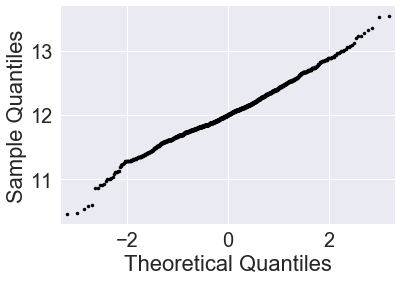

In [35]:
import statsmodels.api as sm

fig = sm.qqplot(train_df['SalePrice'], marker='.', markerfacecolor='k', markeredgecolor='k')

In [36]:
# Label encode categorical variables
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

cat_cols = train_df.select_dtypes(include=['object', 'category'])
for column in cat_cols:
    train_df[column] = le.fit_transform(train_df[column].astype('str'))

In [37]:
cat_cols = test_df.select_dtypes(include=['object', 'category'])
for column in cat_cols:
    test_df[column] = le.fit_transform(test_df[column].astype('str'))

In [38]:
# VIF graphs to identify multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

num_feats = train_df.select_dtypes(include=[np.number])

vif = []
for i in range(1,len(add_constant(num_feats).columns)):
    vif.append(variance_inflation_factor(add_constant(num_feats).values, i))
    
vif = np.array(vif)

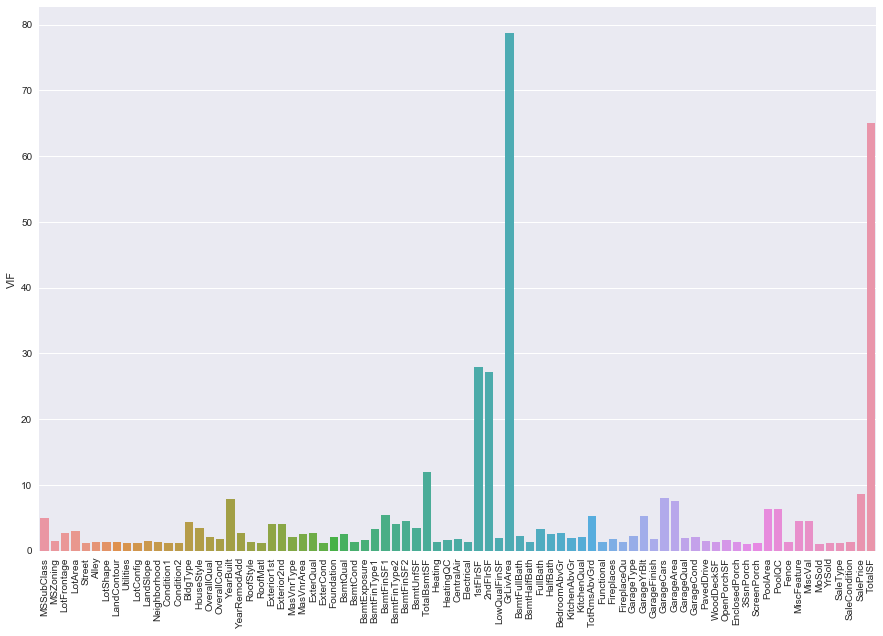

In [39]:
sns.set(font_scale = 1)
f, ax = plt.subplots(figsize=(15,10))
sns.barplot(num_feats.columns.values, vif)
ax.set_ylabel('VIF')
plt.xticks(rotation=90)
plt.show()

In [40]:
# Variable correlations with SalesPrice
correlation = train_df.corr().abs()

unstack = correlation.unstack()

sales_corr = unstack.sort_values(ascending = False)

sales_corr['SalePrice'][:10]

SalePrice      1.000000
TotalSF        0.809303
GrLivArea      0.729344
GarageCars     0.650018
YearBuilt      0.611894
1stFlrSF       0.609901
FullBath       0.583546
ExterQual      0.582164
BsmtQual       0.576969
GarageYrBlt    0.567239
dtype: float64

## Model Pipeline

In [41]:
from sklearn.model_selection import train_test_split

X = train_df.drop(['SalePrice'], axis = 1)
y = train_df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=RANDOM_STATE)

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler # a transformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor # an estimator
from xgboost import XGBRegressor

model = Pipeline([('scaler', StandardScaler()),
                  ('xgb',XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.4,
       gamma=0, learning_rate=0.07, max_delta_step=0, max_depth=3,
       min_child_weight=1.5, missing=None, n_estimators=10000, nthread=-1,
       objective='reg:linear', reg_alpha=0.75, reg_lambda=0.45,
       scale_pos_weight=1, seed=42, silent=True, subsample=0.6))
                 ])

In [43]:
# Fit and Score
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.898441136348923

In [44]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_train, y_train, cv=6)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.88 (+/- 0.04)


In [45]:
from sklearn.metrics import mean_squared_error
from math import sqrt, exp

y_pred = model.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)
RMSE = sqrt(MSE)

print(RMSE)

0.13125869855898584


In [46]:
from sklearn.metrics import r2_score

r2_score(y_test, y_pred)

0.8984411363489231

In [47]:
valid_X = test_df.drop(['Id'], axis = 1)
valid_pred = model.predict(valid_X)

# Inverse Log transformation on SalePrice
test_df['SalePrice'] = np.expm1(valid_pred)

In [48]:
submission = test_df[['Id','SalePrice']]
submission.to_csv('submission.csv', index=False)

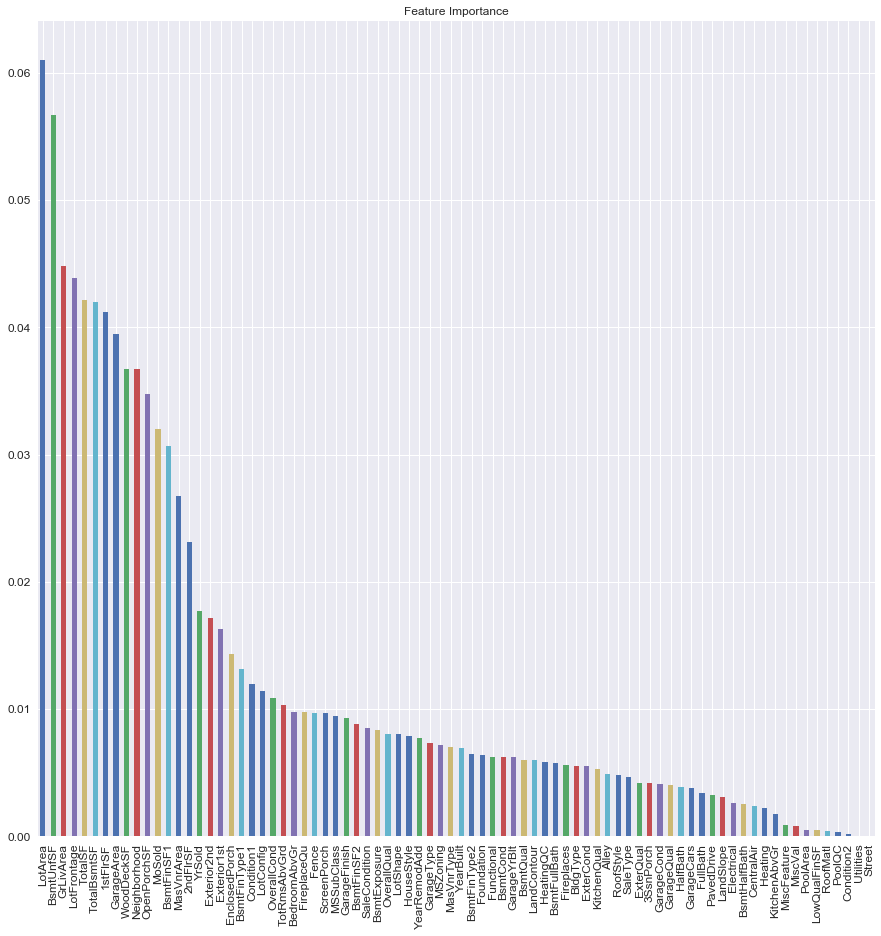

In [49]:
pd.Series(model.named_steps['xgb'].feature_importances_, index=X.columns).sort_values(ascending = False)\
.plot(kind='bar', figsize=(15,15), fontsize=12, title='Feature Importance')

## Parameter Tuning

In [52]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'rfr__n_estimators': n_estimators,
               'rfr__max_features': max_features,
               'rfr__max_depth': max_depth,
               'rfr__min_samples_split': min_samples_split,
               'rfr__min_samples_leaf': min_samples_leaf,
               'rfr__bootstrap': bootstrap}

rfr_random = RandomizedSearchCV(model, random_grid, n_iter=15, cv=3, random_state=RANDOM_STATE, verbose = 2, n_jobs = -1)

# Fit the random search model
rfr_random.fit(X_train, y_train)

# Best score/estimator
best_estimator = rfr_random.best_estimator_
print(f'Best Estimator: {best_estimator}')